For the start, loading the Pokemon.csv dataset.

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
plt.style.use('ggplot')

data=pd.read_csv('../input/pokemon/Pokemon.csv') 
data=data[((data['Legendary']==False) & (data['Generation']==1) & (data['Name'].str.find("Mega")==-1))]

For a better accuracy we want to use information about the type resist for each pokemon.

As this information is not present in the dataset, it develop a scrapper to take from the [Bulbapedia Wiki](http://https://bulbapedia.bulbagarden.net/wiki/Main_Page) this information. 

In [3]:
pokemon_weakness_pd=[]

try:
    pokemon_weakness_pd=pd.read_csv('../input/pokemonweaknessgen1/pokemon_weakness.csv')
except IOError: 
    wiki_link="https://bulbapedia.bulbagarden.net/wiki/"
    type_list=data['Type 1'].unique()
    pokemon_weakness_list=[]
    pattern = re.compile(r'Weak to')  
    
    for pokemon_elm in data['Name']:
        poke_link=pokemon_elm+"_(Pok%C3%A9mon)"
        print(pokemon_elm+" :"+wiki_link+poke_link)
        page = requests.get(wiki_link+poke_link)
        
        if page.status_code != 200:
            break
    
        soup = BeautifulSoup(page.content, 'html.parser')
        weak=soup.find(text=pattern).parent.parent        
        weakness_pkm=[pokemon_elm]
        
        for type_search in type_list:
            multiply=(weak.find(text=re.compile(type_search)).parent.parent.parent.parent.parent).find_all("td")
            if multiply[1].text.find("¼")!=-1:
                weakness_pkm.append(1/4)
            elif multiply[1].text.find("½")!=-1:
                weakness_pkm.append(1/2)
            elif multiply[1].text.find("1")!=-1:
                weakness_pkm.append(1)
            elif multiply[1].text.find("2")!=-1:
                weakness_pkm.append(2)
            elif multiply[1].text.find("4")!=-1:
                weakness_pkm.append(4)
            elif multiply[1].text.find("0")!=-1:
                weakness_pkm.append(0)
            else:
                weakness_pkm.append(multiply[1].text.strip())
        
        pokemon_weakness_list.append(weakness_pkm)
        
    headTable=["Name"]
    
    for types in type_list:
        headTable.append(types)
          
    pokemon_weakness_pd = pd.DataFrame(columns=headTable, data=pokemon_weakness_list)
    pokemon_weakness_pd.index=pokemon_weakness_pd["Name"]
    pokemon_weakness_pd.to_csv("pokemon_weakness.csv")

Next, we will compute a coefficient of weakness based on the resistence values for each pokemon and the number of pokemons corresponding to each type.

In [4]:
data.index=data["Name"]

type_count=data["Type 1"].value_counts()

weakness_coeff=[]

for index, pokemon_elm in pokemon_weakness_pd.iterrows():
    weakness_force=0
    i=1
    for type_elm in pokemon_elm[1:]: 
        if pokemon_weakness_pd.columns.values[i] in type_count.index:
            weakness_force+=type_elm*type_count[pokemon_weakness_pd.columns.values[i]]    
        i+=1      
    weakness_coeff.append(weakness_force)
    
data=data.assign(Weakness=weakness_coeff)

<Figure size 1728x864 with 0 Axes>

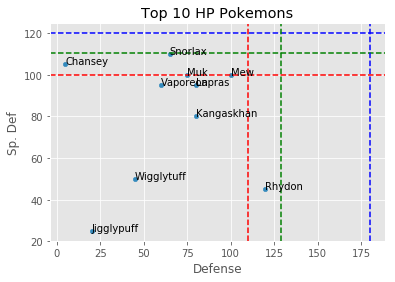

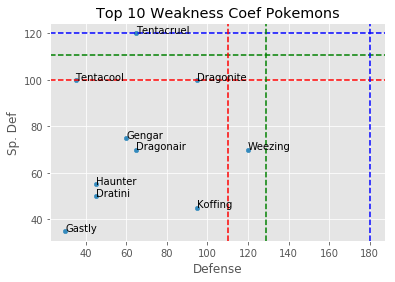

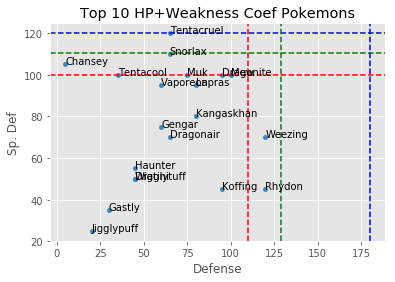

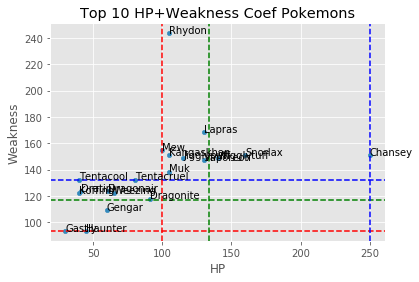

In [13]:

plt.figure(figsize=(24,12))

top_def=data.sort_values(by="Defense", ascending=False).head(10)
top_sdef=data.sort_values(by="Sp. Def", ascending=False).head(10)

top_hp=data.sort_values(by="HP", ascending=False).head(10)
fig1=top_hp.plot(kind='scatter',x='Defense',y='Sp. Def')

plt.title("Top 10 HP Pokemons")

plt.axhline(top_sdef['Sp. Def'].max(),color='blue',linestyle='dashed')
plt.axhline(top_sdef['Sp. Def'].mean(),color='green',linestyle='dashed')
plt.axhline(top_sdef['Sp. Def'].min(),color='red',linestyle='dashed')

plt.axvline(top_def['Defense'].max(),color='blue',linestyle='dashed')
plt.axvline(top_def['Defense'].mean(),color='green',linestyle='dashed')
plt.axvline(top_def['Defense'].min(),color='red',linestyle='dashed')

for i, name in enumerate(top_hp["Name"]):
    fig1.annotate(name, (top_hp.iloc[i]['Defense'], top_hp.iloc[i]['Sp. Def']))


top_weakness=data.sort_values(by="Weakness", ascending=True).head(10)
fig2=top_weakness.plot(kind='scatter',x='Defense',y='Sp. Def')

plt.title("Top 10 Weakness Coef Pokemons")


plt.axhline(top_sdef['Sp. Def'].max(),color='blue',linestyle='dashed')
plt.axhline(top_sdef['Sp. Def'].mean(),color='green',linestyle='dashed')
plt.axhline(top_sdef['Sp. Def'].min(),color='red',linestyle='dashed')

plt.axvline(top_def['Defense'].max(),color='blue',linestyle='dashed')
plt.axvline(top_def['Defense'].mean(),color='green',linestyle='dashed')
plt.axvline(top_def['Defense'].min(),color='red',linestyle='dashed')

for i, name in enumerate(top_weakness["Name"]):
    fig2.annotate(name, (top_weakness.iloc[i]['Defense'], top_weakness.iloc[i]['Sp. Def']))


pokemon_hp_weakness=pd.concat([top_weakness,top_hp])

fig3=pokemon_hp_weakness.plot(kind='scatter',x='Defense',y='Sp. Def')
plt.title("Top 10 HP+Weakness Coef Pokemons")


plt.axhline(top_sdef['Sp. Def'].max(),color='blue',linestyle='dashed')
plt.axhline(top_sdef['Sp. Def'].mean(),color='green',linestyle='dashed')
plt.axhline(top_sdef['Sp. Def'].min(),color='red',linestyle='dashed')

plt.axvline(top_def['Defense'].max(),color='blue',linestyle='dashed')
plt.axvline(top_def['Defense'].mean(),color='green',linestyle='dashed')
plt.axvline(top_def['Defense'].min(),color='red',linestyle='dashed')

for i, name in enumerate(pokemon_hp_weakness["Name"]):
    fig3.annotate(name, (pokemon_hp_weakness.iloc[i]['Defense'], pokemon_hp_weakness.iloc[i]['Sp. Def']))


fig4=pokemon_hp_weakness.plot(kind='scatter',x='HP',y='Weakness')
plt.title("Top 10 HP+Weakness Coef Pokemons")

plt.axhline(top_weakness['Weakness'].max(),color='blue',linestyle='dashed')
plt.axhline(top_weakness['Weakness'].mean(),color='green',linestyle='dashed')
plt.axhline(top_weakness['Weakness'].min(),color='red',linestyle='dashed')

plt.axvline(top_hp['HP'].max(),color='blue',linestyle='dashed')
plt.axvline(top_hp['HP'].mean(),color='green',linestyle='dashed')
plt.axvline(top_hp['HP'].min(),color='red',linestyle='dashed')

for i, name in enumerate(pokemon_hp_weakness["Name"]):
    fig4.annotate(name, (pokemon_hp_weakness.iloc[i]['HP'], pokemon_hp_weakness.iloc[i]['Weakness']))

plt.show()

#top_weakness=data.sort_values(by="weakness", ascending=True).head(10)